In [2]:
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
%load_ext autoreload
%autoreload 2
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PATH_REL_ETE = "data/processed/ete.csv"

In [22]:
def

def get_dataset_ete_equi(conf: config.ExperimentConfig, experiment_path: pathlib.Path) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [5]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/13-EEA1_short+Rab5_10x-long_time/7ded95ff")
PATH_EXPERIMENT_CONNECTED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/13-EEA1_short+Rab5_10x-long_time/7ded95ff')

In [6]:
CONF_CONNECTED = config.read_experiment_config(PATH_EXPERIMENT_CONNECTED / "13-EEA1_short+Rab5_10x-long_time.toml")
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_nod

### Get data

#### ETE

In [23]:
df_ete_conn = get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED)
df_ete_conn

R_x       R_y      R_z          R
kappa d_end molecule-ID t                                               
190.2 15.0  1           20000000   21.1113   3.33798 -51.8683  56.099462
                        20010000   22.3715   3.32621 -50.5283  55.359342
                        20020000   23.9349   1.88956 -48.7609  54.351405
                        20030000   23.1916   2.45618 -52.5876  57.526853
                        20040000   21.0607   3.62511 -53.9827  58.058819
...                                    ...       ...      ...        ...
            50          519960000  44.0820  -8.76189  35.9279  57.539616
                        519970000  46.7452  -9.84358  34.4316  58.885863
                        519980000  48.8575  -8.73757  33.7101  59.998094
                        519990000  47.8816  -9.66420  34.1878  59.622563
                        520000000  47.3523 -10.58040  33.7882  59.125524

[2500050 rows x 4 columns]

#### Kuhn length $l_K$

In [29]:
l_K_estimate_conn: pd.Series = pd.read_csv(PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "l_K-estimate.csv").iloc[0]
l_K_estimate_conn

kappa    190.200000
d_end     15.000000
l_K      381.557725
d_l_K      0.057164
Name: 0, dtype: float64

#### Bond length $l_b$

In [9]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

0.97

#### Contour length L

In [10]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

#### End monomer mass

In [11]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

1.5

#### Friction coefficient of end monomer $\zeta_e$

In [30]:
zeta_end_conn = l_K_estimate_conn["d_end"] / m_end_conn
zeta_end_conn

10.0

#### MSD

In [26]:
df_msd_conn = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_conn)
df_msd_conn["t/LJ"] = df_msd_conn.index.get_level_values("t").map(lambda t: t*0.0025)
df_msd_conn["t/LJ"] = df_msd_conn["t/LJ"] - df_msd_conn["t/LJ"].min()
df_msd_conn

,dR^2,kappa,d_end,t/LJ
t,,,,
20000000,0.000000,190.2,15.0,0.0
20010000,7.470236,190.2,15.0,25.0
20020000,12.636747,190.2,15.0,50.0
20030000,15.733537,190.2,15.0,75.0
20040000,19.781031,190.2,15.0,100.0
...,...,...,...,...
519960000,1154.704684,190.2,15.0,1249900.0
519970000,1161.786071,190.2,15.0,1249925.0
519980000,1160.750226,190.2,15.0,1249950.0


### Explore

#### Log-log MSD

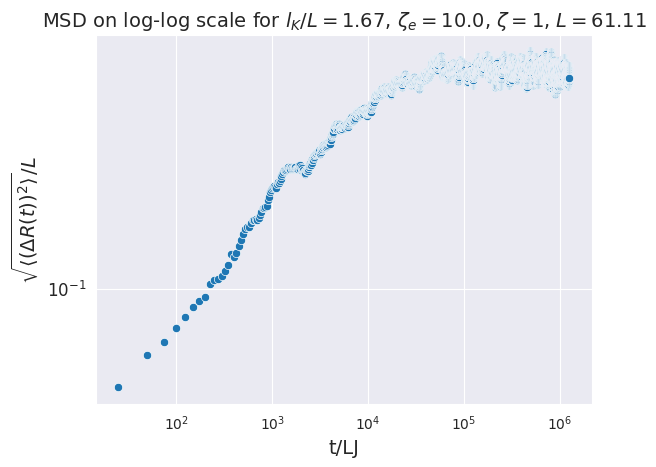

In [32]:
def _plot_msd_log_log():
    df = df_msd_conn.copy()
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour

    ax: plt.Axes = sns.scatterplot(df, x="t/LJ", y=dR_col)
    ax.set(xscale="log", yscale="log", title=f"MSD on log-log scale for $l_K/L=1.67$, $\zeta_e=10.0$, $\zeta=1$, $L={L_contour}$")

_plot_msd_log_log()

In [36]:
def _calculate_window_log_slope(data: pd.Series) -> float:
    return np.polyfit(np.log10(data.index), np.log10(data), 1)[0]

def _calculate_scaling_factor(df_ete_change: pd.DataFrame, window: int):
    return df_ete_change.loc[df_ete_change["t/LJ"] > .0001].groupby(["kappa", "d_end"])[["dR^2", "t/LJ"]].rolling(window=window, on="t/LJ", min_periods=10).apply(
        _calculate_window_log_slope
    )

df_rod_scaling_exp = _calculate_scaling_factor(df_msd_conn, 10000).rename({"dR^2": "alpha"}, axis=1)
df_rod_scaling_exp

alpha       t/LJ
kappa d_end t                             
190.2 15.0  20010000        NaN       25.0
            20020000        NaN       50.0
            20030000        NaN       75.0
            20040000        NaN      100.0
            20050000        NaN      125.0
...                         ...        ...
            519960000 -0.483920  1249900.0
            519970000 -0.484163  1249925.0
            519980000 -0.484416  1249950.0
            519990000 -0.484693  1249975.0
            520000000 -0.484987  1250000.0

[50000 rows x 2 columns]

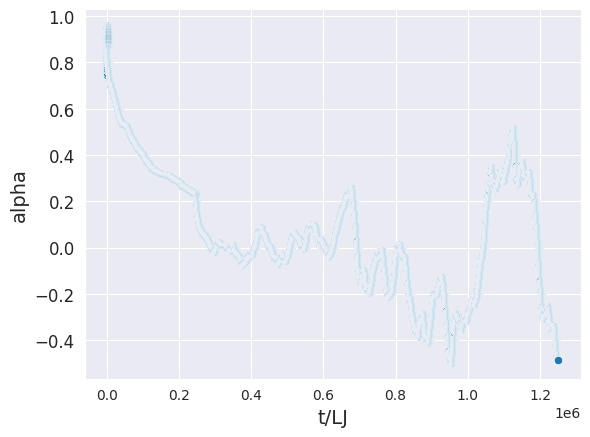

In [37]:
def _plot_scaling_exp():
    sns.scatterplot(
        df_rod_scaling_exp.reset_index(),
        x="t/LJ",
        y="alpha"
    )

_plot_scaling_exp()